In [1]:
import itertools
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os

from scipy import stats

In [2]:
def get_data(data):
    data_array = []
    for row in data['data']['Model_Rs'][0, 0]['R_CV'][0, :]:#[0, 0]:
        data_array.append(row)
    return np.array(data_array).squeeze()


def Analyze_max_sample(data):
    # return (get_data(data).argmax(axis=1))
    return (get_data(data).max(axis=1))
    # return (get_data(data)[:, 1])
    

Model_Mode = 'Time' #["IC", "Channels", "Periods", "Time"];

# Modality = 'EEGfMRI' #'EEGfMRI' 'MMEG'; # EEG2 EEG MEG GMEG GMEG2 GMEG3
Modality = 'MMEG'

if Modality == 'MMEG':
    
    Subjects_list = list(range(1, 18+1));
    Tasks_list = [4] # [1, 2] # list(range(1, 2 + 1));
    Task_name = {4: 'Auditory'}

elif Modality == 'EEGfMRI':

    Subjects_list = list(range(1, 17+1));
    Tasks_list = [1, 2] # list(range(1, 2 + 1));
    Task_name = {1: 'Auditory', 2: 'Visual'}

else:
    pass

Learn_methods_list = ["transition"] #, "frequency"];
SurpriseMethods_list = ["KL2", "LOG", "PUZ"];
# ['early', 'mmn', 'p300', 'all', 'signal']
Periods_list = ["sample", "interval"];


csv_dir = f'csv_reports_{Modality}'
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)
    
ICA_flag = 1;

In [3]:
filepath = os.path.join('..', 'backups', 'Output', 'MEG_Model_sample')
os.listdir(filepath)

['MEG_Decoding_Model_sample_Subject02_Task03_transition_PUZ_interval.mat',
 'MEG_Decoding_Model_sample_Subject02_Task03_transition_PUZ_sample.mat',
 'MEG_Decoding_Model_sample_Subject14_Task04_transition_KL2_sample.mat',
 'MEG_Decoding_Model_sample_Subject07_Task01_transition_log2_sample.mat',
 'MEG_Decoding_Model_sample_Subject10_Task04_transition_log2_interval.mat',
 'MEG_Decoding_Model_sample_Subject07_Task04_transition_PUZ_interval.mat',
 'MEG_Decoding_Model_sample_Subject01_Task04_transition_log2_interval.mat',
 'MEG_Decoding_Model_sample_KL2_sample_transition_Task04_Subject02.mat',
 'MEG_Decoding_Model_sample_Subject09_Task02_transition_log2_sample.mat',
 'MEG_Decoding_Model_sample_KL2_interval_transition_Task04_Subject14.mat',
 'MEG_Decoding_Model_sample_Subject04_Task03_transition_KL2_sample.mat',
 'MEG_Decoding_Model_sample_KL2_sample_transition_Task04_Subject06.mat',
 'MEG_Decoding_Model_sample_Subject08_Task03_transition_PUZ_interval.mat',
 'MEG_Decoding_Model_sample_Subject

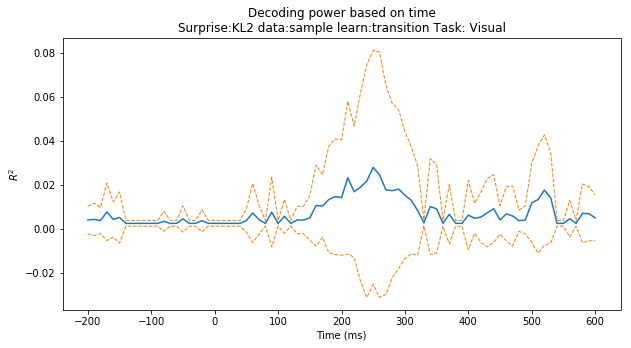

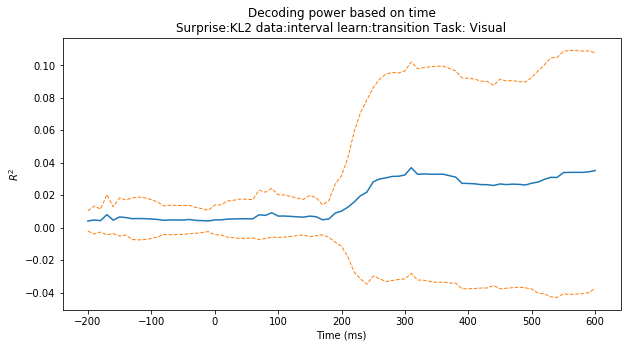

FileNotFoundError: [Errno 2] No such file or directory: '../backups/Output/MEG_Model_sample/MEG_Decoding_Model_sample_Subject01_Task04_transition_LOG_sample.mat'

In [4]:
decoding_powers = {}
for SurpriseMethod in SurpriseMethods_list:
    for Period in Periods_list:
        for learn_method in Learn_methods_list:
            for TaskNumber in Tasks_list:
                res = []
                for Sub in Subjects_list:
                    # filename = f'Run_Model_{Modality}_{Model_Mode}_Subject{Sub:02}_Task{TaskNumber}_{learn_method}_{SurpriseMethod}_{Period}.mat'
                    filename = f'MEG_Decoding_Model_sample_Subject{Sub:02}_Task{TaskNumber:02}_{learn_method}_{SurpriseMethod}_{Period}.mat'
                    # filepath = os.path.join('..', 'Output', f'{Modality}_{Model_Mode}', filename)
                    filepath = os.path.join('..', 'backups', 'Output', 'MEG_Model_sample', filename)
                    # print(filename)
                    data = sio.loadmat(filepath)

                    res.append(Analyze_max_sample(data))

                    fig = plt.figure(figsize=(14, 7))
                    plt.plot(Analyze_max_sample(data))
                    plt.title(f'{SurpriseMethod} {Period} Task{TaskNumber} Sub{Sub:2}')
                    if not os.path.exists(os.path.join('plots', f'r2_sample_{Sub}',)):
                        os.makedirs(os.path.join('plots', f'r2_sample_{Sub}',))
                    plt.savefig(os.path.join('plots', f'r2_sample_{Sub}', f'{SurpriseMethod}_{Period}_{learn_method}_Task{TaskNumber}.png'))
                    # plt.show()
                    plt.close(fig)

                res = np.asarray(res)
                decoding_powers[f'{Period}_{SurpriseMethod}_{TaskNumber}_{learn_method}'] = res
                
                fig = plt.figure(figsize=(10, 5))
                lmean = plt.plot(np.arange(-200, 601, 10), res.mean(axis=0))
                lstd1 = plt.plot(np.arange(-200, 601, 10), res.mean(axis=0) + res.std(axis=0), 
                                 color='#ff7f0e', linestyle='--', linewidth=1)
                lstd2 = plt.plot(np.arange(-200, 601, 10), res.mean(axis=0) - res.std(axis=0),
                                 color='#ff7f0e', linestyle='--', linewidth=1)
                plt.title(f'Decoding power based on time\n' +
                          f'Surprise:{SurpriseMethod} data:{Period} learn:{learn_method} ' + 
                          f'Task: {"Auditory" if TaskNumber == 1 else "Visual"}',)
                # plt.ylim([0, .4])
                plt.xlabel('Time (ms)')
                plt.ylabel(r'$R^2$')
                if not os.path.exists(os.path.join('plots', f'r2_sample',)):
                    os.makedirs(os.path.join('plots', f'r2_sample',))
                # plt.savefig(os.path.join('plots', f'r2_sample', f'{SurpriseMethod}_{Period}_{learn_method}_Task{TaskNumber:02}.png'))
                plt.show()
                plt.close(fig)

In [ ]:
for Period in Periods_list:# sample 'interval']:
    for learn_method in Learn_methods_list:
        for TaskNumber in Tasks_list: #range(1, 3):
            kl2 = decoding_powers[f'{Period}_KL2_{TaskNumber}_{learn_method}']
            log = decoding_powers[f'{Period}_LOG_{TaskNumber}_{learn_method}']
            puz = decoding_powers[f'{Period}_PUZ_{TaskNumber}_{learn_method}']
            # puz2 = decoding_powers[f'{Period}_PUZ2_{TaskNumber}_{learn_method}']
            
            fig = plt.figure(figsize=(14, 7))
            
            plt.plot(range(-200, 601, 10), kl2.mean(axis=0), label='Bayesian', color='#1f77b4')
            
            plt.plot(range(-200, 601, 10), log.mean(axis=0), label='Shannon', color='#ff7f0e')
            
            plt.plot(range(-200, 601, 10), puz.mean(axis=0), label='Confidence Corrected', color='#2ca02c')
            
            # plt.plot(range(-200, 601, 10), puz2.mean(axis=0), label='puz2', color='#d62728')
            
            gca = plt.gca()
            ymin, ymax = plt.ylim()
            plt.plot([0, 0], [ymin, ymax], color='#999999', linestyle='--')
            plt.plot([100, 100], [ymin, ymax], color='#999999', linestyle='--')
            plt.plot([250, 250], [ymin, ymax], color='#999999', linestyle='--')
            plt.sca(gca)
            
            plt.text(-120, ymax*0.9, 'base line')
            plt.text(20, ymax*0.9, 'early')
            plt.text(170, ymax*0.9, 'middle')
            plt.text(300, ymax*0.9, 'late')
            
            plt.xlabel('Time (ms)')
            plt.ylabel(r'$R^2$')
            plt.legend(prop={'size': 12})
            plt.title(f'Task: {TaskNumber} {Period}')
            if not os.path.exists(os.path.join('plots', f'r2_sample_surprise_comparison',)):
                os.makedirs(os.path.join('plots', f'r2_sample_surprise_comparison',))
            plt.savefig(os.path.join('plots', 'r2_sample_surprise_comparison', f'{Period}_{learn_method}_Task{TaskNumber:02}.png'))
            plt.show()
            plt.close(fig)
            
            fig = plt.figure(figsize=(14, 7))
            plt.plot(range(-200, 601, 10), kl2.mean(axis=0), label='Bayesian', color='#1f77b4')
            
            plt.plot(range(-200, 601, 10), log.mean(axis=0), label='Shannon', color='#ff7f0e')
            
            plt.plot(range(-200, 601, 10), puz.mean(axis=0), label='Confidence Corrected', color='#2ca02c')
            
            # plt.plot(range(-200, 601, 10), puz2.mean(axis=0), label='puz2', color='#d62728')
                      
            plt.errorbar(range(-200, 601, 10), kl2.mean(axis=0), kl2.std(axis=0), color='#1f77b4', alpha=0.3)
            
            plt.errorbar(range(-200, 601, 10), log.mean(axis=0), log.std(axis=0), color='#ff7f0e', alpha=0.3)
            
            plt.errorbar(range(-200, 601, 10), puz.mean(axis=0), puz.std(axis=0), color='#2ca02c', alpha=0.3)
            
            plt.fill_between(range(-200, 601, 10), kl2.mean(axis=0) - kl2.std(axis=0),
                             kl2.mean(axis=0) + kl2.std(axis=0), color='#1f77b4', alpha=0.1)
            
            plt.fill_between(range(-200, 601, 10), log.mean(axis=0) - log.std(axis=0),
                             log.mean(axis=0) + log.std(axis=0), color='#ff7f0e', alpha=0.1)
            
            plt.fill_between(range(-200, 601, 10), puz.mean(axis=0) - puz.std(axis=0),
                             puz.mean(axis=0) + puz.std(axis=0), color='#2ca02c', alpha=0.1)
            
            
            plt.plot(range(-200, 601, 10), kl2.mean(axis=0) + kl2.std(axis=0), color='#1f77b4', linestyle='--', linewidth=1)
            plt.plot(range(-200, 601, 10), kl2.mean(axis=0) - kl2.std(axis=0), color='#1f77b4', linestyle='--', linewidth=1)
            
            plt.plot(range(-200, 601, 10), log.mean(axis=0) + log.std(axis=0), color='#ff7f0e', linestyle='--', linewidth=1)
            plt.plot(range(-200, 601, 10), log.mean(axis=0) - log.std(axis=0), color='#ff7f0e', linestyle='--', linewidth=1)
            
            plt.plot(range(-200, 601, 10), puz.mean(axis=0) + puz.std(axis=0), color='#2ca02c', linestyle='--', linewidth=1)
            plt.plot(range(-200, 601, 10), puz.mean(axis=0) - puz.std(axis=0), color='#2ca02c', linestyle='--', linewidth=1)
            
            # plt.plot(range(-200, 601, 10), puz2.mean(axis=0) + puz2.std(axis=0), color='#d62728', linestyle='--', linewidth=1)
            # plt.plot(range(-200, 601, 10), puz2.mean(axis=0) - puz2.std(axis=0), color='#d62728', linestyle='--', linewidth=1)

            plt.xlabel('Time (ms)')
            plt.ylabel(r'$R^2$')
            plt.legend(prop={'size': 12})
            plt.title(f'Task: {TaskNumber} {Period}')
            plt.savefig(os.path.join('plots', 'r2_sample_surprise_comparison', f'Std_{Period}_{learn_method}_Task{TaskNumber:02}.png'))
            plt.show()
            plt.close(fig)

In [ ]:
labels = {
    'KL2':'Bayesian',
    'LOG': 'Shannon',
    'PUZ': 'Confidence Corrected'
}

for Period in Periods_list:
    for learn_method in Learn_methods_list:
        for TaskNumber in Tasks_list:
            fig = plt.figure(figsize=(14, 7))
            
            for sm1, sm2 in itertools.combinations(SurpriseMethods_list, 2):
                sig1 = decoding_powers[f'{Period}_{sm1}_{TaskNumber}_{learn_method}']
                sig2 = decoding_powers[f'{Period}_{sm2}_{TaskNumber}_{learn_method}']
                
                t_values, p_values = stats.ttest_ind(sig1, sig2)
                
                plt.plot(range(-200, 601, 10), p_values, label=f'{labels[sm1]} vs {labels[sm2]}')
                
            plt.plot(range(-200, 601, 10), 0.05 * np.ones((81, )), color='black', linestyle='--', linewidth=1)
                
            plt.xlabel('Time (ms)')
            plt.ylabel(r'$P_{value}$')
            plt.legend(prop={'size': 12})
            plt.title(f'Task: {TaskNumber} {Period}')
            
            gca = plt.gca()
            ymin, ymax = plt.ylim()
            plt.plot([0, 0], [ymin, ymax], color='#999999', linestyle='--')
            plt.plot([100, 100], [ymin, ymax], color='#999999', linestyle='--')
            plt.plot([250, 250], [ymin, ymax], color='#999999', linestyle='--')
            plt.sca(gca)
            
            plt.text(-120, ymax*0.9, 'base line')
            plt.text(20, ymax*0.9, 'early')
            plt.text(170, ymax*0.9, 'middle')
            plt.text(300, ymax*0.9, 'late')
                      
            if not os.path.exists(os.path.join('plots', f'p_sample_surprise_comparison',)):
                os.makedirs(os.path.join('plots', f'p_sample_surprise_comparison',))
            plt.savefig(os.path.join('plots', 'p_sample_surprise_comparison', f'{Period}_{learn_method}_Task{TaskNumber:02}.png'))
            
            plt.show()
            plt.close(fig)

In [ ]:
for Period in Periods_list:
    for learn_method in Learn_methods_list:
        for TaskNumber in Tasks_list:
            for Sub in Subjects_list:
                kl2 = decoding_powers[f'{Period}_KL2_{TaskNumber}_{learn_method}'][Sub - 1]
                log = decoding_powers[f'{Period}_LOG_{TaskNumber}_{learn_method}'][Sub - 1]
                puz = decoding_powers[f'{Period}_PUZ_{TaskNumber}_{learn_method}'][Sub - 1]
                # puz2 = decoding_powers[f'{Period}_PUZ2_{TaskNumber}_{learn_method}'][Sub]

                fig = plt.figure(figsize=(14, 7))
                plt.plot(range(-200, 601, 10), kl2, label='Bayesian', color='#1f77b4')

                plt.plot(range(-200, 601, 10), log, label='Shannon', color='#ff7f0e')

                plt.plot(range(-200, 601, 10), puz, label='Confidence Corrected', color='#2ca02c')

                # plt.plot(range(-200, 601, 10), puz2, label='puz2', color='#d62728')

                plt.xlabel('Time (ms)')
                plt.ylabel(r'$R^2$')
                plt.legend(prop={'size': 12})
                plt.title(f'Task: {TaskNumber} {Period}')
                if not os.path.exists(os.path.join('plots', f'r2_sample_surprise_comparison_{Sub}',)):
                    os.makedirs(os.path.join('plots', f'r2_sample_surprise_comparison_{Sub}',))
                plt.savefig(os.path.join('plots', f'r2_sample_surprise_comparison_{Sub}', f'{Period}_{learn_method}_Task{TaskNumber:02}.png'))
                # plt.show()
                plt.close(fig)

In [ ]:
decoding_powers_w = {}
for SurpriseMethod in SurpriseMethods_list:
    for Period in Periods_list:
        for learn_method in Learn_methods_list:
            for TaskNumber in Tasks_list:
                res = []
                for Sub in Subjects_list:
                    filename = f'Run_Model_{Modality}_{Model_Mode}_Subject{Sub:02}_Task{TaskNumber}_{learn_method}_{SurpriseMethod}_{Period}.mat'
                    filepath = os.path.join('..', 'Output', f'{Modality}_{Model_Mode}', filename)
                    # print(filename)
                    data = sio.loadmat(filepath)

                    res.append(get_data(data))

                res = np.asarray(res)
                decoding_powers_w[f'{Period}_{SurpriseMethod}_{TaskNumber}_{learn_method}'] = res
                

In [ ]:
for Period in Periods_list:
    for learn_method in Learn_methods_list:
        for TaskNumber in Tasks_list:
            for SurpriseMethod in SurpriseMethods_list:
    
                r2 = decoding_powers_w[f'{Period}_{SurpriseMethod}_{TaskNumber}_{learn_method}']
                fig = plt.figure(figsize=(8, 3))
                ax = fig.subplots()
                im = ax.imshow(r2.mean(axis=0).T, origin='lower', interpolation='nearest')
                
                xticks = [''] + np.arange(-200, 601, 100).tolist()
                yticks = [''] + data['data']['Param'][0, 0]['w_Set'][0, 0][0][::5].tolist()
                ax.set_xticklabels(xticks)
                ax.set_yticklabels(yticks)
                
                ax.set_xlabel('Time (ms)')
                ax.set_ylabel(r'$\omega$')
                
                cbar = ax.figure.colorbar(im, ax=ax, fraction=0.0128, pad=0.02)
                
                ax.set_title(f'Heatmap of $R^2$ on $\omega$\n'
                             f'{Period} {SurpriseMethod} {TaskNumber}')
                fig.tight_layout()
                if not os.path.exists(os.path.join('plots', 'heatmaps',)):
                    os.makedirs(os.path.join('plots', 'heatmaps',))
                plt.savefig(os.path.join('plots', 'heatmaps',f'{Period}_{SurpriseMethod}_{TaskNumber}_{learn_method}.png'))
#                 plt.show()
                plt.close(fig)

In [ ]:
for Period in Periods_list:
    for learn_method in Learn_methods_list:
        for TaskNumber in Tasks_list:
            for SurpriseMethod in SurpriseMethods_list:
                for Sub in Subjects_list:
    
                    r2 = decoding_powers_w[f'{Period}_{SurpriseMethod}_{TaskNumber}_{learn_method}'][Sub-1]
                    fig = plt.figure(figsize=(8, 3))
                    ax = fig.subplots()
                    im = ax.imshow(r2.T, origin='lower', interpolation='nearest')

                    xticks = [''] + np.arange(-200, 601, 100).tolist()
                    yticks = [''] + data['data']['Param'][0, 0]['w_Set'][0, 0][0][::5].tolist()
                    ax.set_xticklabels(xticks)
                    ax.set_yticklabels(yticks)

                    ax.set_xlabel('Time (ms)')
                    ax.set_ylabel(r'$\omega$')

                    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.0128, pad=0.02)

                    ax.set_title(f'Heatmap of $R^2$ on $\omega$\n'
                                 f'{Period} {SurpriseMethod} {"Auditory" if TaskNumber == 1 else "Visual"} Subject {Sub}')
                    fig.tight_layout()
                    if not os.path.exists(os.path.join('plots', f'heatmaps_{Sub}',)):
                        os.makedirs(os.path.join('plots', f'heatmaps_{Sub}',))
                    plt.savefig(os.path.join('plots', f'heatmaps_{Sub}',f'{Period}_{SurpriseMethod}_{"Auditory" if TaskNumber == 1 else "Visual"}_{learn_method}.png'))
    #                 plt.show()
                    plt.close(fig)

In [ ]:
pv = {}

for SurpriseMethod in SurpriseMethods_list:
    for Period in Periods_list:
        for learn_method in Learn_methods_list:
            for TaskNumber in Tasks_list:
                sig = decoding_powers[f'{Period}_{SurpriseMethod}_{TaskNumber}_{learn_method}']
                pv[f'{Period}_{SurpriseMethod}_{TaskNumber}_{learn_method}'] = np.zeros((80, 80))
                print(f'{Period}_{SurpriseMethod}_{TaskNumber}_{learn_method}')
                
                for i in range(80):
                    for j in range(80):
                        t_values, p_values = stats.ttest_ind(sig[:, i], sig[:, j])
                        pv[f'{Period}_{SurpriseMethod}_{TaskNumber}_{learn_method}'][i, j] = p_values

In [ ]:
for SurpriseMethod in SurpriseMethods_list:
    for Period in Periods_list:
        for learn_method in Learn_methods_list:
            for TaskNumber in Tasks_list:
                if not os.path.exists(os.path.join('csv_reports',)):
                    os.makedirs(os.path.join('csv_reports'))
                np.savetxt(os.path.join('csv_reports',
                                        f'{Period}_{SurpriseMethod}_{TaskNumber}_{learn_method}.csv'),
                           pv[f'{Period}_{SurpriseMethod}_{TaskNumber}_{learn_method}'], 
                           delimiter=",")
                    
                print(os.path.join('csv_reports', f'{Period}_{SurpriseMethod}_{TaskNumber}_{learn_method}.csv'))

                fig = plt.figure(figsize=(8, 8))
                ax = fig.subplots()
                im = ax.imshow(pv[f'{Period}_{SurpriseMethod}_{TaskNumber}_{learn_method}'],
                               origin='lower', interpolation='nearest')
                
                xticks = [''] + np.arange(-200, 601, 100).tolist()
                yticks = [''] + np.arange(-200, 601, 100).tolist()
                ax.set_xticklabels(xticks)
                ax.set_yticklabels(yticks)
                
                ax.set_xlabel('Time (ms)')
                ax.set_xlabel('Time (ms)')
                
                cbar = ax.figure.colorbar(im, ax=ax, fraction=0.0128, pad=0.02,)
#                                           norm=colors.LogNorm(vmin=1e-6, vmax=1))
                
                ax.set_title('Heatmap of $P_{value}$\n'
                             f'{Period} {SurpriseMethod} {"Auditory" if TaskNumber == 1 else "Visual"}')
                fig.tight_layout()
                if not os.path.exists(os.path.join('plots', 'P_value_time_time',)):
                    os.makedirs(os.path.join('plots', 'P_value_time_time',))
                plt.savefig(os.path.join('plots', 'P_value_time_time',
                                         f'{Period}_{SurpriseMethod}_{"Auditory" if TaskNumber == 1 else "Visual"}_{learn_method}.png'))
                # plt.show()
                plt.close(fig)
                

# ANOVA

In [ ]:
pv = {}

for SurpriseMethod in SurpriseMethods_list:
    for Period in Periods_list:
        for learn_method in Learn_methods_list:
            for TaskNumber in Tasks_list:
                sig = decoding_powers[f'{Period}_{SurpriseMethod}_{TaskNumber}_{learn_method}']
                pv[f'{Period}_{SurpriseMethod}_{TaskNumber}_{learn_method}'] = np.zeros((80, 80))
                print(f'{Period}_{SurpriseMethod}_{TaskNumber}_{learn_method}')
                
                for i in range(80):
                    for j in range(80):
                        t_values, p_values = stats.ttest_ind(*sig[:, :])
                        pv[f'{Period}_{SurpriseMethod}_{TaskNumber}_{learn_method}'][i, j] = p_values